# Task1: Play with NetVLAD

## Work done last week (Evil version i.e., bad version)
which we will show later it is indeed bad.

work adapted from https://github.com/lyakaap/NetVLAD-pytorch

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable

from PIL import Image
from netvlad_evil import NetVLAD
from netvlad_evil import EmbedNet
from hard_triplet_loss import HardTripletLoss
from torchvision.models import resnet18

def VLAD_for_single_image_evil(img):
    # Discard layers at the end of base network
    encoder = resnet18(pretrained=True)
    base_model = nn.Sequential(
        encoder.conv1,
        encoder.bn1,
        encoder.relu,
        encoder.maxpool,
        encoder.layer1,
        encoder.layer2,
        encoder.layer3,
        encoder.layer4
    )
    dim = list(base_model.parameters())[-1].shape[0]  # last channels (512)

    # Define model for embedding
    net_vlad = NetVLAD(num_clusters=64, dim=dim, alpha=1.0)
    model = EmbedNet(base_model, net_vlad)

    # Define loss
    criterion = HardTripletLoss(margin=0.1)

    preprocess = transforms.Compose([
        transforms.ToTensor(),
    ])
    x = preprocess(img)
    x = x.unsqueeze(0)
    
    output = model(x)

    print('VLAD encoding: {}'.format(output))
    print('VLAD encoding shape: {}'.format(output.shape))

    return output

## Work done this week (Works great! Yay!)
adapted from https://github.com/Nanne/pytorch-NetVlad

### Adapt main.py
Define a function VLAD_for_single_image for our use.

In [2]:
from __future__ import print_function
import random
from os.path import join, isfile

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
import numpy as np
import netvlad

def VLAD_for_single_image(img):
    cuda = False
    if cuda and not torch.cuda.is_available():
        raise Exception("No GPU found, please run with --nocuda")

    device = torch.device("cuda" if cuda else "cpu")

    default_seed = 123
    random.seed(default_seed)
    np.random.seed(default_seed)
    torch.manual_seed(default_seed)
    if cuda:
        torch.cuda.manual_seed(default_seed)

    print('===> Loading data')
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225]),
    ])
    input = preprocess(img)
    input = input.unsqueeze(0)
    print('Input image shape: {}'.format(input.shape))

    print('===> Building model')

    pretrained = True

    encoder_dim = 512
    encoder = models.vgg16(pretrained=pretrained)
    # capture only feature part and remove last relu and maxpool
    layers = list(encoder.features.children())[:-2]

    if pretrained:
        # if using pretrained then only train conv5_1, conv5_2, and conv5_3
        for l in layers[:-5]: 
            for p in l.parameters():
                p.requires_grad = False


    encoder = nn.Sequential(*layers)
    model = nn.Module() 
    model.add_module('encoder', encoder)

    default_num_clusters = 64
    defauly_vladv2 = False
    print('NetVLAD setting:\nnum_clusters: {} dim: {} vladv2: {}'.format(default_num_clusters, encoder_dim, defauly_vladv2))
    net_vlad = netvlad.NetVLAD(num_clusters=default_num_clusters, dim=encoder_dim, vladv2=defauly_vladv2)
    model.add_module('pool', net_vlad)

    checkpoint_path = 'vgg16_netvlad_checkpoint'
    resume_ckpt = join(checkpoint_path, 'checkpoints', 'checkpoint.pth.tar')

    if isfile(resume_ckpt):
        print("=> loading checkpoint '{}'".format(resume_ckpt))
        checkpoint = torch.load(resume_ckpt, map_location=lambda storage, loc: storage)
        start_epoch = checkpoint['epoch']
        best_metric = checkpoint['best_score']
        model.load_state_dict(checkpoint['state_dict'])
        model = model.to(device)
        print("=> loaded checkpoint '{}' (epoch {})"
                .format(resume_ckpt, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(resume_ckpt))

    print('===> Running evaluation step')
    model.eval()
    with torch.no_grad():
        input = input.to(device)
        image_encoding = model.encoder(input)
        vlad_encoding = model.pool(image_encoding) 
    print('VLAD encoding: {}'.format(vlad_encoding))
    print('VLAD encoding shape: {}'.format(vlad_encoding.shape))
    return vlad_encoding

### Functionality Test 
Note: _evil indicates the NetVLAD model from last week, which is consider to be written in evil coding style

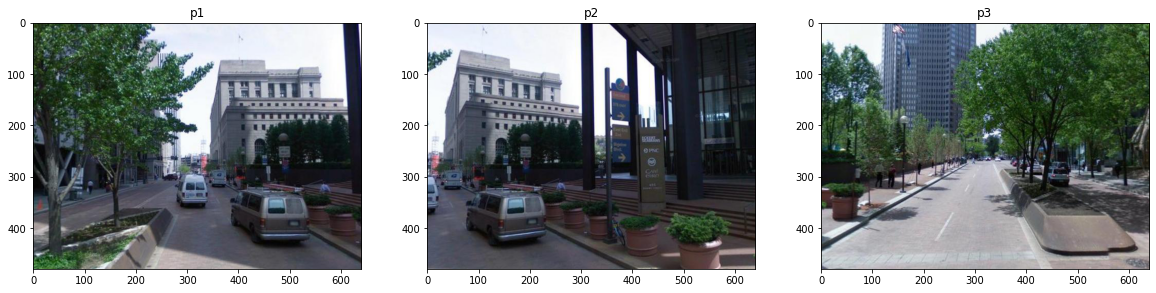

In [3]:
import matplotlib.pyplot as plt
from PIL import Image
p1 = Image.open('./000/q1.jpg')
p2 = Image.open('./000/q2.jpg')
p3 = Image.open('./000/q3.jpg')
plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
plt.title('p1')
plt.imshow(p1)
plt.subplot(1, 3, 2)
plt.title('p2')
plt.imshow(p2)
plt.subplot(1, 3, 3)
plt.title('p3')
plt.imshow(p3)

In [4]:
p1_vlad = VLAD_for_single_image(p1)
p2_vlad = VLAD_for_single_image(p2)
p3_vlad = VLAD_for_single_image(p3)
p1_vlad_evil = VLAD_for_single_image_evil(p1)
p2_vlad_evil = VLAD_for_single_image_evil(p2)
p3_vlad_evil = VLAD_for_single_image_evil(p3)

===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step


/opt/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


VLAD encoding: tensor([[ 7.1684e-04,  6.6962e-03,  4.6199e-04,  ...,  1.1777e-02,
          5.3189e-03, -8.2096e-05]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([[ 0.0008,  0.0054, -0.0057,  ...,  0.0049,  0.0074, -0.0076]])
VLAD encoding shape: torch.Size([1, 32768])
===> Loading data
Input image shape: torch.Size([1, 3, 480, 640])
===> Building model
NetVLAD setting:
num_clusters: 64 dim: 512 vladv2: False
=> loading checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar'
=> loaded checkpoint 'vgg16_netvlad_checkpoint/checkpoints/checkpoint.pth.tar' (epoch 25)
===> Running evaluation step
VLAD encoding: tensor([

In [5]:
cos = nn.CosineSimilarity(dim=1, eps=1e-6)
output_similar = cos(p1_vlad, p2_vlad)
output_diff = cos(p1_vlad, p3_vlad)
print('Cosine Similarity \nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar, output_diff))
print('\n')
output_similar_evil = cos(p1_vlad_evil, p2_vlad_evil)
output_diff_evil = cos(p1_vlad_evil, p3_vlad_evil)
print('Cosine Similarity (Evil model) \nfor similar scenes: {}, \nfor different scenes: {}'.format(output_similar_evil, output_diff_evil))

Cosine Similarity 
for similar scenes: tensor([0.3917]), 
for different scenes: tensor([0.2119])


Cosine Similarity (Evil model) 
for similar scenes: tensor([0.7308], grad_fn=<DivBackward0>), 
for different scenes: tensor([0.7310], grad_fn=<DivBackward0>)


In this week's good NetVLAD, for this example, the cosine similarity of similar scenes is almost twice as the different ones. While in last week's evil NetVLAD, the cosine similarity of different scenes is hilariously higher than the similar ones, LOL

# Task2: .json reader (for 3RScan)

In [6]:
#by Linda Wang
import json
PRINT_ALL_JSON = False

#load entire json file for raw data
def load_json(name):
    with open(name) as f:
      data = json.load(f)
    return data

#helper functions
def extract_centroid(data):
    return data["centroid"]

def printing_format(id,centroid,lable):
    print("===================================")
    print("Object ID: {}".format(id))
    print("Centoid Info: x: {}, y: {}, z: {}".format(centroid[0],centroid[1],centroid[2]))
    print("Label: {}".format(lable))


#extract objectID, label and centroid
def extract_segGroup_info(data):

    id_dict = {}
    label_dict = {}

    #loop through all segGroup objects
    for object_dict in data["segGroups"]:
        #object_dict includes: objectId, id, partId, index, dominantNormal, obb, segments, label

        #get needed info
        id = object_dict["objectId"]
        centroid = extract_centroid(object_dict["obb"])
        lable = object_dict["label"]

        #print
        #printing_format(id,centroid,lable)
        id_dict[id] = [lable, centroid]

        if lable in label_dict:
            label_dict[lable].append([id, centroid])
        else:
            label_dict[lable] = [[id, centroid]]
        #print("object id is: {}, the centroid is: {} and the label is: {}".format(id,centroid,lable))

    return id_dict, label_dict

# Task3: 3RScan Library and Renderer

## 1) Compare given 3D file against rendered 3D file

In [ ]:
import open3d as o3d
from os.path import join

data_path = './3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193'
given_ply = join(data_path, 'labels.instances.annotated.v2.ply')
rendered_ply = join(data_path, 'labels.instances.annotated.v2.align.ply')
given_obj = join(data_path, 'mesh.refined.v2.obj')
rendered_obj = join(data_path, 'mesh.refined.v2.align.obj')

In [ ]:
print("Load a ply point cloud, print it, and render it")
pcd = o3d.io.read_point_cloud(rendered_ply)
print(pcd)
print(np.asarray(pcd.points))
o3d.visualization.draw_geometries([pcd])

In [ ]:
print("Let's draw a textured triangle mesh from obj file.")
textured_mesh = o3d.io.read_triangle_mesh(given_obj)
textured_mesh.compute_vertex_normals()
o3d.visualization.draw_geometries([textured_mesh])

I can't see any difference, let's use 'diff' to check.

In [ ]:
!diff ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/labels.instances.annotated.v2.ply \
./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/labels.instances.annotated.v2.align.ply

In [ ]:
!diff ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/mesh.refined.v2.obj \
./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/mesh.refined.v2.align.obj

I guess the only difference is orientation.

## 2) Render for each frame

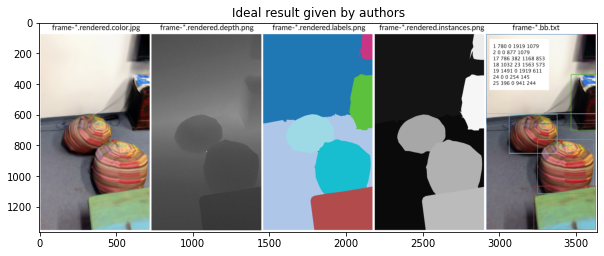

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from os.path import join
from PIL import Image
import matplotlib.image as mpimg
ideal = Image.open('./3RScan-master/data/img/frames.png')
plt.figure(figsize=(10, 10))
plt.title('Ideal result given by authors')
plt.imshow(ideal)

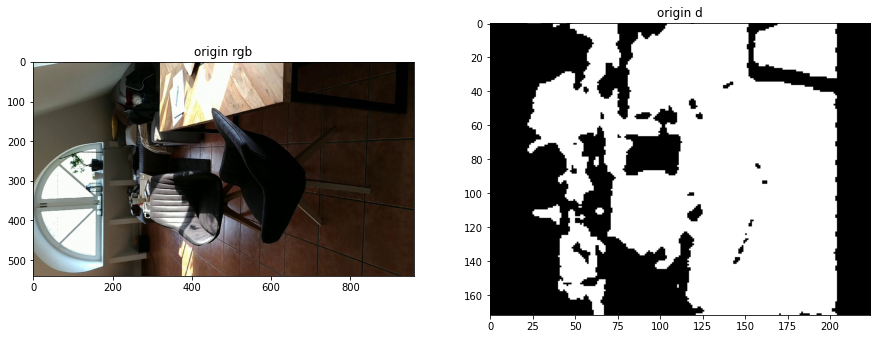

In [8]:
img_path = './3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/sequence'
p1 = Image.open(join(img_path, 'frame-000000.color.jpg'))
p2 = Image.open(join(img_path, 'frame-000000.depth.pgm'))
plt.figure(figsize=(15, 15))
plt.subplot(121)
plt.title('origin rgb')
plt.imshow(p1)
plt.subplot(122)
plt.title('origin d')
plt.imshow(p2)

In [9]:
!cat ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/sequence/frame-000000.visibility.txt

1 216976 629103 0.344897 895171 1.30263e+06 0.687203
2 24648 184615 0.13351 92264 94213 0.979313
3 1746 162805 0.0107245 6026 6026 1
4 43702 43702 1 172400 173463 0.993872
5 56771 170692 0.332593 209043 259135 0.806695
6 4396 4396 1 17573 27475 0.6396
7 1442 2893 0.498445 5761 7293 0.789936
18 23221 25757 0.901541 93061 194772 0.477795
33 44598 97897 0.45556 178946 183926 0.972924
34 44454 44454 1 177710 179131 0.992067
35 30303 30303 1 121174 124922 0.969997
41 1407 1407 1 5618 5618 1
45 6 6 1 22 1566 0.0140485
46 128 128 1 496 1114 0.445242
47 70 70 1 255 7628 0.0334295
48 1451 1451 1 5810 6887 0.843618
49 1197 1197 1 4754 7762 0.612471
51 1128 1128 1 4572 16195 0.282309
52 814 814 1 3240 4338 0.746888
53 591 591 1 2333 14940 0.156158
54 2727 2727 1 10911 27560 0.3959
72 7244 7283 0.994645 29003 29284 0.990404
100 1315 1315 1 5287 30243 0.174817


In [10]:
!cat ./3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/sequence/frame-000000.bb.txt

1 577 0 1919 1079
2 0 0 507 295
3 0 0 227 51
4 0 405 388 1054
5 0 156 582 1079
6 386 399 606 1009
7 517 983 585 1079
18 410 0 867 626
33 648 0 1337 355
34 904 221 1664 898
35 598 530 1134 913
41 516 863 600 955
45 507 655 514 664
46 496 625 519 654
47 507 434 515 486
48 445 316 547 430
49 429 206 510 325
51 432 293 716 454
52 499 646 542 768
53 581 310 638 419
54 498 554 619 760
72 473 0 623 318
100 513 610 621 808


In [11]:
file_name = './3RScan-master/data/3RScan/19eda6f4-55aa-29a0-8893-8eac3a4d8193/semseg.v2.json'
data = load_json(file_name)

# to print all json info
if PRINT_ALL_JSON:
    print(data)

#printing only object ID, centoid and label
id_dict, label_dict = extract_segGroup_info(data)

#dictionary organized by id, and dictionary organized by label
print(label_dict['chair'])
print(id_dict[34])

[[35, [-0.2731783146346658, 2.362736870670112, -1.041575607845735]], [34, [-0.06098989559655388, 1.3978452467264315, -1.0517860918837938]]]
['chair', [-0.06098989559655388, 1.3978452467264315, -1.0517860918837938]]


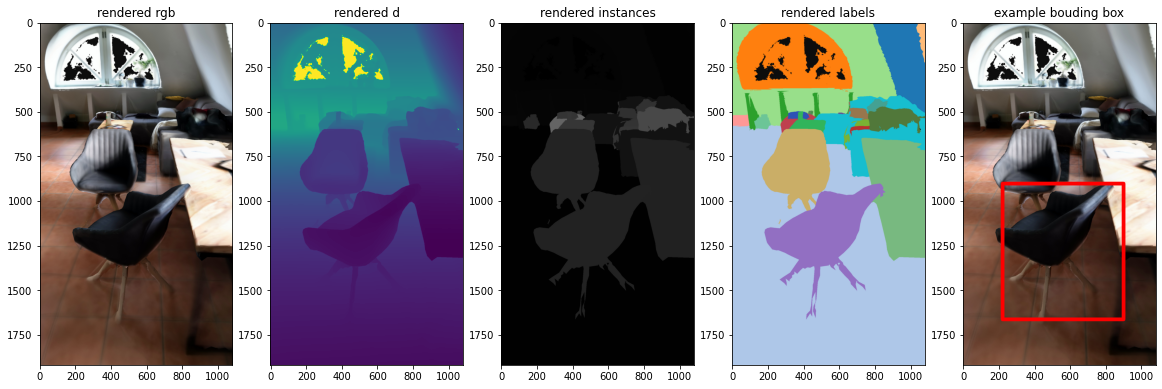

In [12]:
r1 = Image.open(join(img_path, 'frame-000000.rendered.color.jpg'))
# r2 = Image.open(join(img_path, 'frame-000000.rendered.depth.png'))
r2 = mpimg.imread(join(img_path, 'frame-000000.rendered.depth.png'))
r3 = Image.open(join(img_path, 'frame-000000.rendered.instances.png'))
r4 = Image.open(join(img_path, 'frame-000000.rendered.labels.png'))
r5 = Image.open(join(img_path, 'frame-000000.rendered.color.jpg'))

plt.figure(figsize=(20, 20))

plt.subplot(151)
plt.title('rendered rgb')
plt.imshow(r1)

plt.subplot(152)
plt.title('rendered d')
plt.imshow(r2)
# plt.subplot(152)
# plt.title('rendered d')
# plt.imshow(r2)

plt.subplot(153)
plt.title('rendered instances')
plt.imshow(r3)

plt.subplot(154)
plt.title('rendered labels')
plt.imshow(r4)

plt.subplot(155)
plt.title('example bouding box')
r5 = np.array(r5)
# label:chair id:34 bb:(904 221 1664 898) Note: numpy index is reversed i.e., (x,y) -> (y,x)
cv2.rectangle(r5,pt1=(898,1664),pt2=(221,904),color=(255,0,0),thickness=20)
plt.imshow(r5)

We can also use ./rio_renderer to visualize all the bounding boxes. Below is the result.

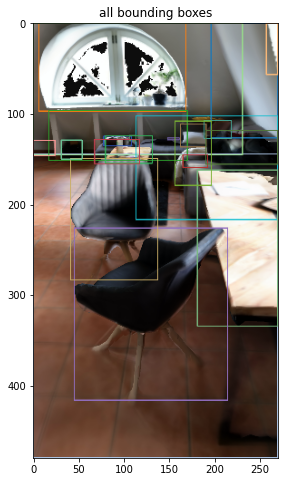

In [13]:
bb = Image.open('./Bounding Boxes_screenshot_19.05.2022.png')
plt.figure(figsize=(8, 8))
plt.subplot(111)
plt.title('all bounding boxes')
plt.imshow(bb)